In [20]:
import requests
from bs4 import BeautifulSoup
import re
import json
import pandas as pd

import yfinance as yf
import numpy as np
from sklearn.cluster import KMeans

In [2]:
def get_stock_advice(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        middle_section = soup.find('div', {'class': 'middle_section'})
        data = []
        if middle_section:
            news_list = middle_section.find('ul', {'class': 'news_list'})
            if news_list:
                articles = news_list.find_all('li')
                for article in articles:
                    stock_info = article.find('div', {'class': 'rb_gd14'})
                    stock_name_link = stock_info.find('a')
                    stock_name = stock_name_link.get_text(strip=True)
                    stock_price = stock_info.find_all('strong')[1].get_text(strip=True).replace(',', '')
                    try:
                        stock_price_float = float(stock_price)
                    except ValueError:
                        stock_price_float = 0.0
                    article_link = article.find('div', {'class': 'MT5'}).find('a')
                    recommendation = article_link.get_text(strip=True)
                    recommendation_parts = recommendation.split(':')
                    if len(recommendation_parts) > 1:
                        recommendation_trimmed = recommendation_parts[0].split(';')[0].strip()
                        source = recommendation_parts[-1].strip()
                    else:
                        recommendation_trimmed = recommendation
                        source = ''
                    match = re.search(r'target of Rs (\d+[:,]?\d+)', recommendation)
                    if match:
                        target_value = match.group(1).replace(',', '')
                        try:
                            target_value_float = float(target_value)
                        except ValueError:
                            target_value_float = 0.0
                    else:
                        target_value = ''
                        target_value_float = 0.0
                    revenue = target_value_float - stock_price_float
                    if stock_price_float != 0:
                        profit_percent = (revenue / stock_price_float) * 100
                    else:
                        profit_percent = 0.0
                    data.append({
                        'Stock Name': stock_name,
                        'Price': f'Rs {stock_price}',
                        'Recommendation': recommendation_trimmed,
                        'Target Price': target_value,
                        'Source': source,
                        'Revenue': f'Rs {revenue:.2f}',
                        'Profit Percent': f'{profit_percent:.2f}%'
                    })
            else:
                return {'error': 'No news list found on the page.'}
        else:
            return {'error': 'No middle section found on the page.'}
    else:
        return {'error': 'Failed to retrieve the webpage.'}
    return data

url = 'https://m.moneycontrol.com/markets/stock-advice/'
all_recommended_stocks = get_stock_advice(url)
print(json.dumps(all_recommended_stocks, indent=4))


[
    {
        "Stock Name": "HDFC Bank",
        "Price": "Rs 1517.20",
        "Recommendation": "Buy HDFC Bank",
        "Target Price": "1850",
        "Source": "ICICI Securities",
        "Revenue": "Rs 332.80",
        "Profit Percent": "21.94%"
    },
    {
        "Stock Name": "Tejas Networks",
        "Price": "Rs 1155.20",
        "Recommendation": "Buy Tejas Networks",
        "Target Price": "1100",
        "Source": "Emkay Global Financial",
        "Revenue": "Rs -55.20",
        "Profit Percent": "-4.78%"
    },
    {
        "Stock Name": "Bajaj Finance",
        "Price": "Rs 6836.90",
        "Recommendation": "Buy Bajaj Finance",
        "Target Price": "9000",
        "Source": "Emkay Global Financial",
        "Revenue": "Rs 2163.10",
        "Profit Percent": "31.64%"
    },
    {
        "Stock Name": "Bajaj Finance",
        "Price": "Rs 6836.90",
        "Recommendation": "Buy Bajaj Finance",
        "Target Price": "9000",
        "Source": "Emkay Global Fin

In [6]:
data = pd.DataFrame(all_recommended_stocks)

In [7]:
data

,Stock Name,Price,Recommendation,Target Price,Source,Revenue,Profit Percent
0,HDFC Bank,Rs 1517.20,Buy HDFC Bank,1850,ICICI Securities,Rs 332.80,21.94%
1,Tejas Networks,Rs 1155.20,Buy Tejas Networks,1100,Emkay Global Financial,Rs -55.20,-4.78%
2,Bajaj Finance,Rs 6836.90,Buy Bajaj Finance,9000,Emkay Global Financial,Rs 2163.10,31.64%
3,Bajaj Finance,Rs 6836.90,Buy Bajaj Finance,9000,Emkay Global Financial,Rs 2163.10,31.64%
4,Persistent,Rs 3555.20,Reduce Persistent Systems,3700,Emkay Global Financial,Rs 144.80,4.07%
5,Aditya Birla F,Rs 290.05,Reduce Aditya Birla Fashion and Retail,230,Emkay Global Financial,Rs -60.05,-20.70%
6,Wipro,Rs 463.65,Reduce Wipro,410,ICICI Securities,Rs -53.65,-11.57%
7,HDFC Life,Rs 565.10,Buy HDFC Life Insurance Company,739,ICICI Securities,Rs 173.90,30.77%
8,Patel Eng,Rs 62.55,Buy Patel Engineering,80,ICICI Direct,Rs 17.45,27.90%
9,Infosys,Rs 1465.10,Accumulate Infosys,1531,KR Choksey,Rs 65.90,4.50%


In [8]:
data['Recommendation'] = data['Recommendation'].apply(lambda x: x.split()[0])

In [9]:
data

,Stock Name,Price,Recommendation,Target Price,Source,Revenue,Profit Percent
0,HDFC Bank,Rs 1517.20,Buy,1850,ICICI Securities,Rs 332.80,21.94%
1,Tejas Networks,Rs 1155.20,Buy,1100,Emkay Global Financial,Rs -55.20,-4.78%
2,Bajaj Finance,Rs 6836.90,Buy,9000,Emkay Global Financial,Rs 2163.10,31.64%
3,Bajaj Finance,Rs 6836.90,Buy,9000,Emkay Global Financial,Rs 2163.10,31.64%
4,Persistent,Rs 3555.20,Reduce,3700,Emkay Global Financial,Rs 144.80,4.07%
5,Aditya Birla F,Rs 290.05,Reduce,230,Emkay Global Financial,Rs -60.05,-20.70%
6,Wipro,Rs 463.65,Reduce,410,ICICI Securities,Rs -53.65,-11.57%
7,HDFC Life,Rs 565.10,Buy,739,ICICI Securities,Rs 173.90,30.77%
8,Patel Eng,Rs 62.55,Buy,80,ICICI Direct,Rs 17.45,27.90%
9,Infosys,Rs 1465.10,Accumulate,1531,KR Choksey,Rs 65.90,4.50%


In [14]:
data["Recommendation"].unique()

array(['Buy', 'Reduce', 'Accumulate', 'Sell'], dtype=object)

In [16]:
# Extract stock symbols from all recommendations
recommended_stocks = [stock['Stock Name'] for stock in all_recommended_stocks]
print("Recommended Stocks:", recommended_stocks)

Recommended Stocks: ['HDFC Bank', 'Tejas Networks', 'Bajaj Finance', 'Bajaj Finance', 'Persistent', 'Aditya Birla F', 'Wipro', 'HDFC Life', 'Patel Eng', 'Infosys', 'Jindal Drilling', 'Navneet', 'INDUS TOWERS', 'City Union Bank', 'Hatsun Agro', 'Guj State Petro', 'Adani Ports', 'Aditya Birla F', 'Persistent', 'HDFC Life', 'Bajaj Auto', 'Bajaj Auto', 'HDFC Bank', 'Infosys', 'Guj State Petro']


In [33]:
import requests
import time

API_KEY = "069RB5L2HX6TQ48M"  # You need to sign up at https://www.alphavantage.co/support/#api-key

def get_ticker_symbol_alpha_vantage(company_name):
    base_url = "https://www.alphavantage.co/query"
    params = {
        "function": "SYMBOL_SEARCH",
        "keywords": company_name,
        "apikey": API_KEY
    }
    try:
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            result = response.json()
            if 'bestMatches' in result and result['bestMatches']:
                return result['bestMatches'][0]['1. symbol']
            else:
                print(f"No matches found for {company_name}. Response: {result}")
        else:
            print(f"Error fetching data for {company_name}: HTTP {response.status_code}")
    except Exception as e:
        print(f"Exception fetching data for {company_name}: {e}")
    return None

# Add retry mechanism
def get_ticker_symbols_with_retries(company_names, retries=3, delay=2):
    tickers = []
    for company_name in company_names:
        ticker = None
        for attempt in range(retries):
            ticker = get_ticker_symbol_alpha_vantage(company_name)
            if ticker:
                tickers.append(ticker)
                break
            else:
                print(f"Retrying {company_name}... (Attempt {attempt + 1})")
                time.sleep(delay)
        if ticker is None:
            print(f"Failed to get ticker for {company_name} after {retries} attempts")
    return tickers

# Example of dynamic mapping
recommended_stocks = ['HDFC Bank', 'Tejas Networks', 'Bajaj Finance', 'Persistent', 'Aditya Birla F', 'Wipro', 'HDFC Life', 'Patel Eng', 'Infosys', 'Jindal Drilling', 'Navneet', 'INDUS TOWERS', 'City Union Bank', 'Hatsun Agro', 'Guj State Petro', 'Adani Ports', 'Bajaj Auto']
tickers = get_ticker_symbols_with_retries(recommended_stocks)
tickers = list(filter(None, tickers))  # Remove None values
print(tickers)


No matches found for Patel Eng. Response: {'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
Retrying Patel Eng... (Attempt 1)
No matches found for Patel Eng. Response: {'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
Retrying Patel Eng... (Attempt 2)
No matches found for Patel Eng. Response: {'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
Retrying Patel Eng... (Attempt 3)
Failed to get ticker for Patel Eng after 3 attempts
No matches found f

KeyboardInterrupt: 

In [43]:
import requests
import time

# Your Finnhub API key
FINNHUB_API_KEY = "cp9h6fpr01qo7b1ad0e0cp9h6fpr01qo7b1ad0eg"

def get_ticker_symbol(company_name, retries=5, delay=1):
    base_url = "https://finnhub.io/api/v1/search"
    params = {
        "q": company_name,
        "token": FINNHUB_API_KEY
    }
    for attempt in range(retries):
        try:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                result = response.json()
                if 'result' in result and result['result']:
                    symbol = result['result'][0]['symbol']
                    print(f"Found symbol for {company_name}: {symbol}")
                    return symbol
                else:
                    print(f"No results found for {company_name}. Response: {result}")
            elif response.status_code == 429:
                print(f"Rate limit exceeded for {company_name}. Waiting before retrying... (Attempt {attempt + 1})")
                time.sleep(delay)
                delay *= 2  # Exponential backoff
            else:
                print(f"Error fetching data for {company_name}: HTTP {response.status_code}")
        except Exception as e:
            print(f"Exception fetching data for {company_name}: {e}")
        time.sleep(1)  # Sleep between requests to avoid rate limiting
    print(f"Failed to get ticker for {company_name} after {retries} attempts")
    return None

# Example of dynamic mapping
recommended_stocks = [
    'HDFC Bank', 'Tejas Networks', 'Bajaj Finance', 'Persistent', 
    'Aditya Birla F', 'Wipro', 'HDFC Life', 'Patel Eng', 
    'Infosys', 'Jindal Drilling', 'Navneet', 'INDUS TOWERS', 
    'City Union Bank', 'Hatsun Agro', 'Guj State Petro', 
    'Adani Ports', 'Bajaj Auto'
]

# Add a sleep period between each request
tickers = []
for stock in recommended_stocks:
    ticker = get_ticker_symbol(stock)
    if ticker:
        tickers.append(ticker)
    time.sleep(1)  # Sleep to avoid rate limiting

tickers = list(filter(None, tickers))  # Remove None values
print(tickers)


Found symbol for HDFC Bank: HDB
Exception fetching data for Tejas Networks: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Found symbol for Tejas Networks: 540595.BO
Found symbol for Bajaj Finance: BAJFINANCE.NS
Found symbol for Persistent: PERSISTENT.NS
Exception fetching data for Aditya Birla F: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Found symbol for Aditya Birla F: BSLGOLDETF.NS
Found symbol for Wipro: WIPRO.NS


KeyboardInterrupt: 

In [42]:
import yfinance as yf

def fetch_stock_data(stocks, period='1mo'):
    stock_data = {}
    for stock in stocks:
        try:
            print(f"Fetching data for {stock}...")
            ticker = yf.Ticker(stock)
            stock_history = ticker.history(period=period)
            if not stock_history.empty:
                stock_data[stock] = stock_history
                print(f"Data for {stock}: {stock_history.head()}")
            else:
                print(f"{stock}: No data found, symbol may be delisted or incorrectly formatted")
        except Exception as e:
            print(f"{stock}: Error fetching data - {e}")
    return stock_data

stock_data = fetch_stock_data(tickers)
print(stock_data)


Fetching data for HDB...
Data for HDB:                                 Open       High        Low      Close  \
Date                                                                    
2024-04-25 00:00:00-04:00  58.029999  58.410000  57.770000  58.330002   
2024-04-26 00:00:00-04:00  58.340000  58.750000  58.180000  58.340000   
2024-04-29 00:00:00-04:00  58.520000  58.689999  58.250000  58.330002   
2024-04-30 00:00:00-04:00  58.000000  58.520000  57.389999  57.599998   
2024-05-01 00:00:00-04:00  57.820000  58.580002  57.680000  58.139999   

                            Volume  Dividends  Stock Splits  
Date                                                         
2024-04-25 00:00:00-04:00  1686700        0.0           0.0  
2024-04-26 00:00:00-04:00  1434900        0.0           0.0  
2024-04-29 00:00:00-04:00  1532200        0.0           0.0  
2024-04-30 00:00:00-04:00  1587100        0.0           0.0  
2024-05-01 00:00:00-04:00  2295200        0.0           0.0  
Fetching data f

532702.BO: No data found, symbol may be delisted


532702.BO: No data found, symbol may be delisted or incorrectly formatted
Fetching data for ADANIPORTS.NS...
Data for ADANIPORTS.NS:                                   Open         High          Low        Close  \
Date                                                                            
2024-04-24 00:00:00+05:30  1331.000000  1332.900024  1318.050049  1320.500000   
2024-04-25 00:00:00+05:30  1320.500000  1336.949951  1316.800049  1330.550049   
2024-04-26 00:00:00+05:30  1340.000000  1341.599976  1321.099976  1324.599976   
2024-04-29 00:00:00+05:30  1334.300049  1335.750000  1307.000000  1317.250000   
2024-04-30 00:00:00+05:30  1323.550049  1334.650024  1316.250000  1324.900024   

                            Volume  Dividends  Stock Splits  
Date                                                         
2024-04-24 00:00:00+05:30  2553035        0.0           0.0  
2024-04-25 00:00:00+05:30  6097087        0.0           0.0  
2024-04-26 00:00:00+05:30  2565490        0.0      

In [45]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


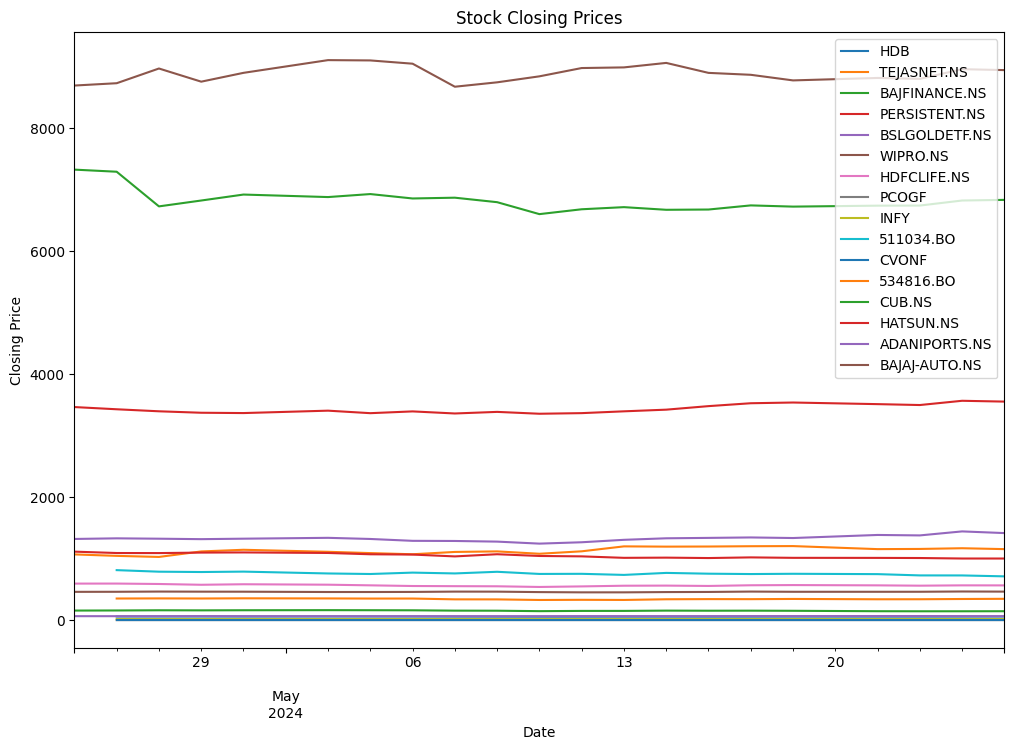

In [47]:
def plot_stock_data(stock_data):
    plt.figure(figsize=(12, 8))
    for stock, data in stock_data.items():
        data['Close'].plot(label=stock)
    plt.title('Stock Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

plot_stock_data(stock_data)

# Option 1

In [54]:
def calculate_metrics(stock_data):
    metrics = {}
    for stock, data in stock_data.items():
        data['Return'] = data['Close'].pct_change()
        volatility = data['Return'].std() * np.sqrt(252 / len(data))
        avg_return = data['Return'].mean() * 252 / len(data)
        metrics[stock] = {'Volatility': volatility, 'Avg_Return': avg_return}
    return metrics

metrics = calculate_metrics(stock_data)
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


               Volatility  Avg_Return
HDB              0.036227   -0.002469
TEJASNET.NS      0.115169    0.052708
BAJFINANCE.NS    0.070114   -0.039215
PERSISTENT.NS    0.034694    0.015756
BSLGOLDETF.NS    0.032854    0.001817
WIPRO.NS         0.026693    0.005212
HDFCLIFE.NS      0.046710   -0.029054
PCOGF            0.363819    0.004224
INFY             0.024351    0.011397
511034.BO        0.085151   -0.084346
CVONF            0.000000    0.000000
534816.BO        0.054444   -0.007987
CUB.NS           0.072324   -0.039978
HATSUN.NS        0.049594   -0.062234
ADANIPORTS.NS    0.067413    0.044146
BAJAJ-AUTO.NS    0.056894    0.018639


In [55]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
metrics_df['Risk_Level'] = kmeans.fit_predict(metrics_df[['Volatility', 'Avg_Return']])

risk_mapping = {0: "low", 1: "mid", 2: "high"}
metrics_df['Risk_Level'] = metrics_df['Risk_Level'].map(risk_mapping)
print(metrics_df)

               Volatility  Avg_Return Risk_Level
HDB              0.036227   -0.002469        low
TEJASNET.NS      0.115169    0.052708        low
BAJFINANCE.NS    0.070114   -0.039215       high
PERSISTENT.NS    0.034694    0.015756        low
BSLGOLDETF.NS    0.032854    0.001817        low
WIPRO.NS         0.026693    0.005212        low
HDFCLIFE.NS      0.046710   -0.029054       high
PCOGF            0.363819    0.004224        mid
INFY             0.024351    0.011397        low
511034.BO        0.085151   -0.084346       high
CVONF            0.000000    0.000000        low
534816.BO        0.054444   -0.007987        low
CUB.NS           0.072324   -0.039978       high
HATSUN.NS        0.049594   -0.062234       high
ADANIPORTS.NS    0.067413    0.044146        low
BAJAJ-AUTO.NS    0.056894    0.018639        low


In [65]:
def allocate_investments(metrics_df, risk_levels, investment_amount):
    allocation = {}
    for risk in risk_levels:
        stocks_in_risk = metrics_df[metrics_df['Risk_Level'] == risk]
        num_stocks = len(stocks_in_risk)
        amount_per_stock = investment_amount / (len(risk_levels) * num_stocks)
        
        for stock in stocks_in_risk.index:
            if risk not in allocation:
                allocation[risk] = []
            allocation[risk].append({
                'Stock': stock,
                'Investment': amount_per_stock,
                'Target_Price': stocks_in_risk.loc[stock, 'Avg_Return'] * 1.2  # Example target price
            })
    return allocation

investment_amount = 10000  # Total investment amount
risk_levels = ["low", "mid", "high"]
allocation = allocate_investments(metrics_df, risk_levels, investment_amount)
for key, value in allocation.items():
    print(f"{key}:\n{value} \n")

low:
[{'Stock': 'HDB', 'Investment': 333.3333333333333, 'Target_Price': -0.002962907109732857}, {'Stock': 'TEJASNET.NS', 'Investment': 333.3333333333333, 'Target_Price': 0.06324926046056946}, {'Stock': 'PERSISTENT.NS', 'Investment': 333.3333333333333, 'Target_Price': 0.018907782609147366}, {'Stock': 'BSLGOLDETF.NS', 'Investment': 333.3333333333333, 'Target_Price': 0.0021798768157797084}, {'Stock': 'WIPRO.NS', 'Investment': 333.3333333333333, 'Target_Price': 0.0062545835246014024}, {'Stock': 'INFY', 'Investment': 333.3333333333333, 'Target_Price': 0.013676590757466791}, {'Stock': 'CVONF', 'Investment': 333.3333333333333, 'Target_Price': 0.0}, {'Stock': '534816.BO', 'Investment': 333.3333333333333, 'Target_Price': -0.009584687770133247}, {'Stock': 'ADANIPORTS.NS', 'Investment': 333.3333333333333, 'Target_Price': 0.05297548992776152}, {'Stock': 'BAJAJ-AUTO.NS', 'Investment': 333.3333333333333, 'Target_Price': 0.022366581842036635}] 

mid:
[{'Stock': 'PCOGF', 'Investment': 3333.33333333333

In [66]:
def generate_recommendations(allocation):
    recommendations = {}
    for risk, stocks in allocation.items():
        recommendations[risk] = []
        for stock_info in stocks:
            recommendation = {
                'Stock': stock_info['Stock'],
                'Invest': stock_info['Investment'],
                'Sell_At': stock_info['Target_Price']
            }
            recommendations[risk].append(recommendation)
    return recommendations

recommendations = generate_recommendations(allocation)
print(json.dumps(recommendations, indent=4))

{
    "low": [
        {
            "Stock": "HDB",
            "Invest": 333.3333333333333,
            "Sell_At": -0.002962907109732857
        },
        {
            "Stock": "TEJASNET.NS",
            "Invest": 333.3333333333333,
            "Sell_At": 0.06324926046056946
        },
        {
            "Stock": "PERSISTENT.NS",
            "Invest": 333.3333333333333,
            "Sell_At": 0.018907782609147366
        },
        {
            "Stock": "BSLGOLDETF.NS",
            "Invest": 333.3333333333333,
            "Sell_At": 0.0021798768157797084
        },
        {
            "Stock": "WIPRO.NS",
            "Invest": 333.3333333333333,
            "Sell_At": 0.0062545835246014024
        },
        {
            "Stock": "INFY",
            "Invest": 333.3333333333333,
            "Sell_At": 0.013676590757466791
        },
        {
            "Stock": "CVONF",
            "Invest": 333.3333333333333,
            "Sell_At": 0.0
        },
        {
            "Sto

# Option 2

In [67]:
import yfinance as yf
import pandas as pd
import numpy as np

def fetch_stock_data(stocks, period='1mo'):
    stock_data = {}
    for stock in stocks:
        try:
            print(f"Fetching data for {stock}...")
            ticker = yf.Ticker(stock)
            stock_history = ticker.history(period=period)
            if not stock_history.empty:
                stock_data[stock] = stock_history
                print(f"Data for {stock}: {stock_history.head()}")
            else:
                print(f"{stock}: No data found, symbol may be delisted or incorrectly formatted")
        except Exception as e:
            print(f"{stock}: Error fetching data - {e}")
    return stock_data

tickers = [
    "HDB", "TEJASNET.NS", "BAJFINANCE.NS", "PERSISTENT.NS", "ABFRL.NS", 
    "WIPRO.NS", "HDFCLIFE.NS", "PATELENG.NS", "INFY", "JINDALDRILL.NS", 
    "NAVNETEDUL.NS", "INDUSTOWER.NS", "CUB.NS", "HATSUN.NS", "GSPL.NS", 
    "ADANIPORTS.NS", "BAJAJ-AUTO.NS"
]

# Fetch data for the last 6 months
stock_data = fetch_stock_data(tickers, period='6mo')

def calculate_metrics(stock_data):
    metrics = []
    for stock, data in stock_data.items():
        data['Return'] = data['Close'].pct_change()
        volatility = data['Return'].std() * np.sqrt(252)  # Annualized volatility
        avg_return = data['Return'].mean() * 252  # Annualized return
        metrics.append({
            'Stock': stock,
            'Volatility': volatility,
            'Return': avg_return
        })
    return pd.DataFrame(metrics)

metrics_df = calculate_metrics(stock_data)
print(metrics_df)


Fetching data for HDB...
Data for HDB:                                 Open       High        Low      Close  \
Date                                                                    
2023-11-27 00:00:00-05:00  59.250000  59.480000  58.860001  58.889999   
2023-11-28 00:00:00-05:00  59.000000  59.730000  58.770000  59.349998   
2023-11-29 00:00:00-05:00  59.860001  60.799999  59.740002  60.549999   
2023-11-30 00:00:00-05:00  60.310001  60.820000  59.810001  60.040001   
2023-12-01 00:00:00-05:00  59.500000  60.830002  59.270000  60.709999   

                            Volume  Dividends  Stock Splits  
Date                                                         
2023-11-27 00:00:00-05:00  1360700        0.0           0.0  
2023-11-28 00:00:00-05:00  2119200        0.0           0.0  
2023-11-29 00:00:00-05:00  3120800        0.0           0.0  
2023-11-30 00:00:00-05:00  2394500        0.0           0.0  
2023-12-01 00:00:00-05:00  1818800        0.0           0.0  
Fetching data f

JINDALDRILL.NS: No data found, symbol may be delisted


JINDALDRILL.NS: No data found, symbol may be delisted or incorrectly formatted
Fetching data for NAVNETEDUL.NS...
Data for NAVNETEDUL.NS:                                  Open        High         Low       Close  \
Date                                                                        
2023-11-24 00:00:00+05:30  141.000000  141.000000  137.000000  138.199997   
2023-11-28 00:00:00+05:30  138.500000  139.449997  137.100006  137.649994   
2023-11-29 00:00:00+05:30  138.399994  138.800003  137.000000  137.350006   
2023-11-30 00:00:00+05:30  138.000000  138.500000  136.600006  137.500000   
2023-12-01 00:00:00+05:30  138.199997  147.000000  137.850006  143.750000   

                            Volume  Dividends  Stock Splits  
Date                                                         
2023-11-24 00:00:00+05:30   159070        0.0           0.0  
2023-11-28 00:00:00+05:30   121113        0.0           0.0  
2023-11-29 00:00:00+05:30    87666        0.0           0.0  
2023-11-30 0

            Stock  Volatility    Return  Cluster Risk Level
0             HDB    0.275265  0.007295        0       High
1     TEJASNET.NS    0.585658  0.907702        1        Mid
2   BAJFINANCE.NS    0.255790 -0.023325        0       High
3   PERSISTENT.NS    0.291489  0.284481        2        Low
4        ABFRL.NS    0.405834  0.587551        2        Low
5        WIPRO.NS    0.269179  0.374189        2        Low
6     HDFCLIFE.NS    0.230941 -0.327647        0       High
7     PATELENG.NS    0.573653  0.592489        2        Low
8            INFY    0.214878  0.021630        0       High
9   NAVNETEDUL.NS    0.371123  0.316356        2        Low
10  INDUSTOWER.NS    0.435040  1.419706        1        Mid
11         CUB.NS    0.287515  0.027391        0       High
12      HATSUN.NS    0.268571 -0.147381        0       High
13        GSPL.NS    0.458123  0.240634        2        Low
14  ADANIPORTS.NS    0.374686  1.291510        1        Mid
15  BAJAJ-AUTO.NS    0.260713  0.906188 

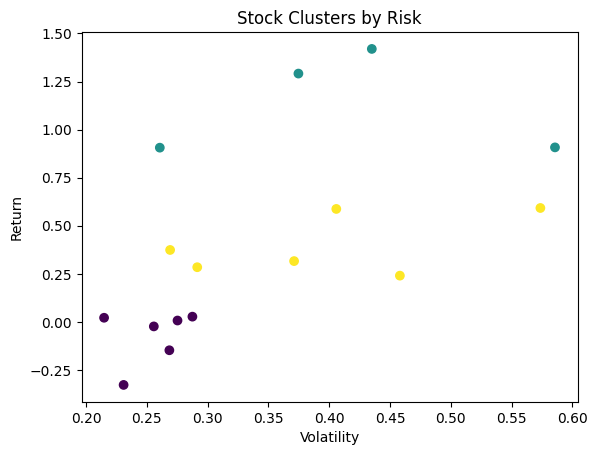

In [68]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Prepare the data for clustering
X = metrics_df[['Volatility', 'Return']]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
metrics_df['Cluster'] = kmeans.labels_

# Define the risk levels based on clusters
risk_levels = ['High', 'Mid', 'Low']
metrics_df['Risk Level'] = metrics_df['Cluster'].apply(lambda x: risk_levels[x])

# Display the clustered data
print(metrics_df)

# Plot the clusters
plt.scatter(metrics_df['Volatility'], metrics_df['Return'], c=metrics_df['Cluster'], cmap='viridis')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Stock Clusters by Risk')
plt.show()


In [72]:
stock_data_json = [
    {"Stock Name": "HDFC Bank", "Price": "Rs 1517.20", "Recommendation": "Buy HDFC Bank", "Target Price": "1850", "Source": "ICICI Securities", "Revenue": "Rs 332.80", "Profit Percent": "21.94%"},
    {"Stock Name": "Tejas Networks", "Price": "Rs 1155.20", "Recommendation": "Buy Tejas Networks", "Target Price": "1100", "Source": "Emkay Global Financial", "Revenue": "Rs -55.20", "Profit Percent": "-4.78%"},
    {"Stock Name": "Bajaj Finance", "Price": "Rs 6836.90", "Recommendation": "Buy Bajaj Finance", "Target Price": "9000", "Source": "Emkay Global Financial", "Revenue": "Rs 2163.10", "Profit Percent": "31.64%"},
    {"Stock Name": "Persistent", "Price": "Rs 3555.20", "Recommendation": "Reduce Persistent Systems", "Target Price": "3700", "Source": "Emkay Global Financial", "Revenue": "Rs 144.80", "Profit Percent": "4.07%"},
    {"Stock Name": "Aditya Birla F", "Price": "Rs 290.05", "Recommendation": "Reduce Aditya Birla Fashion and Retail", "Target Price": "230", "Source": "Emkay Global Financial", "Revenue": "Rs -60.05", "Profit Percent": "-20.70%"},
    {"Stock Name": "Wipro", "Price": "Rs 463.65", "Recommendation": "Reduce Wipro", "Target Price": "410", "Source": "ICICI Securities", "Revenue": "Rs -53.65", "Profit Percent": "-11.57%"},
    {"Stock Name": "HDFC Life", "Price": "Rs 565.10", "Recommendation": "Buy HDFC Life Insurance Company", "Target Price": "739", "Source": "ICICI Securities", "Revenue": "Rs 173.90", "Profit Percent": "30.77%"},
    {"Stock Name": "Patel Eng", "Price": "Rs 62.55", "Recommendation": "Buy Patel Engineering", "Target Price": "80", "Source": "ICICI Direct", "Revenue": "Rs 17.45", "Profit Percent": "27.90%"},
    {"Stock Name": "Infosys", "Price": "Rs 1465.10", "Recommendation": "Accumulate Infosys", "Target Price": "1531", "Source": "KR Choksey", "Revenue": "Rs 65.90", "Profit Percent": "4.50%"},
    {"Stock Name": "Jindal Drilling", "Price": "Rs 710.50", "Recommendation": "Buy Jindal Drilling and Industries", "Target Price": "960", "Source": "Anand Rathi", "Revenue": "Rs 249.50", "Profit Percent": "35.12%"},
    {"Stock Name": "Navneet", "Price": "Rs 155.25", "Recommendation": "Buy Navneet Education", "Target Price": "182", "Source": "Prabhudas Lilladher", "Revenue": "Rs 26.75", "Profit Percent": "17.23%"},
    {"Stock Name": "INDUS TOWERS", "Price": "Rs 346.70", "Recommendation": "Sell Indus Tower", "Target Price": "260", "Source": "ICICI Securities", "Revenue": "Rs -86.70", "Profit Percent": "-25.01%"},
    {"Stock Name": "City Union Bank", "Price": "Rs 144.85", "Recommendation": "Buy City Union Bank", "Target Price": "170", "Source": "ICICI Securities", "Revenue": "Rs 25.15", "Profit Percent": "17.36%"},
    {"Stock Name": "Hatsun Agro", "Price": "Rs 1002.10", "Recommendation": "Buy Hatsun Agro Products", "Target Price": "1190", "Source": "ICICI Securities", "Revenue": "Rs 187.90", "Profit Percent": "18.75%"},
    {"Stock Name": "Guj State Petro", "Price": "Rs 295.65", "Recommendation": "Buy Gujarat State Petronet", "Target Price": "355", "Source": "Motilal Oswal", "Revenue": "Rs 59.35", "Profit Percent": "20.07%"},
    {"Stock Name": "Adani Ports", "Price": "Rs 1416.10", "Recommendation": "Buy Adani Port & SEZ", "Target Price": "1590", "Source": "Motilal Oswal", "Revenue": "Rs 173.90", "Profit Percent": "12.28%"},
    {"Stock Name": "Aditya Birla F", "Price": "Rs 290.05", "Recommendation": "Buy Aditya Birla Fashion & Retail", "Target Price": "297", "Source": "Sharekhan", "Revenue": "Rs 6.95", "Profit Percent": "2.40%"},
    {"Stock Name": "Persistent", "Price": "Rs 3555.20", "Recommendation": "Buy Persistent Systems", "Target Price": "4150", "Source": "Sharekhan", "Revenue": "Rs 594.80", "Profit Percent": "16.73%"},
    {"Stock Name": "HDFC Life", "Price": "Rs 565.10", "Recommendation": "Buy HDFC Life Insurance Co", "Target Price": "745", "Source": "KR Choksey", "Revenue": "Rs 179.90", "Profit Percent": "31.84%"},
    {"Stock Name": "Bajaj Auto", "Price": "Rs 8948.20", "Recommendation": "Reduce Bajaj Auto", "Target Price": "7900", "Source": "Emkay", "Revenue": "Rs -1048.20", "Profit Percent": "-11.71%"},
    {"Stock Name": "HDFC Bank", "Price": "Rs 1517.20", "Recommendation": "Buy HDFC Bank", "Target Price": "2000", "Source": "Emkay", "Revenue": "Rs 482.80", "Profit Percent": "31.82%"},
    {"Stock Name": "Infosys", "Price": "Rs 1465.10", "Recommendation": "Buy Infosys", "Target Price": "1750", "Source": "Emkay", "Revenue": "Rs 284.90", "Profit Percent": "19.45%"},
    {"Stock Name": "Guj State Petro", "Price": "Rs 295.65", "Recommendation": "Reduce Gujarat State Petronet", "Target Price": "370", "Source": "Emkay", "Revenue": "Rs 74.35", "Profit Percent": "25.15%"}
]

In [76]:
# Your initial stock data
stock_data_json = [
    {"Stock Name": "HDFC Bank", "Price": "Rs 1517.20", "Recommendation": "Buy HDFC Bank", "Target Price": "1850", "Source": "ICICI Securities", "Revenue": "Rs 332.80", "Profit Percent": "21.94%"},
    {"Stock Name": "Tejas Networks", "Price": "Rs 1155.20", "Recommendation": "Buy Tejas Networks", "Target Price": "1100", "Source": "Emkay Global Financial", "Revenue": "Rs -55.20", "Profit Percent": "-4.78%"},
    {"Stock Name": "Bajaj Finance", "Price": "Rs 6836.90", "Recommendation": "Buy Bajaj Finance", "Target Price": "9000", "Source": "Emkay Global Financial", "Revenue": "Rs 2163.10", "Profit Percent": "31.64%"},
    {"Stock Name": "Persistent", "Price": "Rs 3555.20", "Recommendation": "Reduce Persistent Systems", "Target Price": "3700", "Source": "Emkay Global Financial", "Revenue": "Rs 144.80", "Profit Percent": "4.07%"},
    {"Stock Name": "Aditya Birla F", "Price": "Rs 290.05", "Recommendation": "Reduce Aditya Birla Fashion and Retail", "Target Price": "230", "Source": "Emkay Global Financial", "Revenue": "Rs -60.05", "Profit Percent": "-20.70%"},
    {"Stock Name": "Wipro", "Price": "Rs 463.65", "Recommendation": "Reduce Wipro", "Target Price": "410", "Source": "ICICI Securities", "Revenue": "Rs -53.65", "Profit Percent": "-11.57%"},
    {"Stock Name": "HDFC Life", "Price": "Rs 565.10", "Recommendation": "Buy HDFC Life Insurance Company", "Target Price": "739", "Source": "ICICI Securities", "Revenue": "Rs 173.90", "Profit Percent": "30.77%"},
    {"Stock Name": "Patel Eng", "Price": "Rs 62.55", "Recommendation": "Buy Patel Engineering", "Target Price": "80", "Source": "ICICI Direct", "Revenue": "Rs 17.45", "Profit Percent": "27.90%"},
    {"Stock Name": "Infosys", "Price": "Rs 1465.10", "Recommendation": "Accumulate Infosys", "Target Price": "1531", "Source": "KR Choksey", "Revenue": "Rs 65.90", "Profit Percent": "4.50%"},
    {"Stock Name": "Jindal Drilling", "Price": "Rs 710.50", "Recommendation": "Buy Jindal Drilling and Industries", "Target Price": "960", "Source": "Anand Rathi", "Revenue": "Rs 249.50", "Profit Percent": "35.12%"},
    {"Stock Name": "Navneet", "Price": "Rs 155.25", "Recommendation": "Buy Navneet Education", "Target Price": "182", "Source": "Prabhudas Lilladher", "Revenue": "Rs 26.75", "Profit Percent": "17.23%"},
    {"Stock Name": "INDUS TOWERS", "Price": "Rs 346.70", "Recommendation": "Sell Indus Tower", "Target Price": "260", "Source": "ICICI Securities", "Revenue": "Rs -86.70", "Profit Percent": "-25.01%"},
    {"Stock Name": "City Union Bank", "Price": "Rs 144.85", "Recommendation": "Buy City Union Bank", "Target Price": "170", "Source": "ICICI Securities", "Revenue": "Rs 25.15", "Profit Percent": "17.36%"},
    {"Stock Name": "Hatsun Agro", "Price": "Rs 1002.10", "Recommendation": "Buy Hatsun Agro Products", "Target Price": "1190", "Source": "ICICI Securities", "Revenue": "Rs 187.90", "Profit Percent": "18.75%"},
    {"Stock Name": "Guj State Petro", "Price": "Rs 295.65", "Recommendation": "Buy Gujarat State Petronet", "Target Price": "355", "Source": "Motilal Oswal", "Revenue": "Rs 59.35", "Profit Percent": "20.07%"},
    {"Stock Name": "Adani Ports", "Price": "Rs 1416.10", "Recommendation": "Buy Adani Port & SEZ", "Target Price": "1590", "Source": "Motilal Oswal", "Revenue": "Rs 173.90", "Profit Percent": "12.28%"},
    {"Stock Name": "Aditya Birla F", "Price": "Rs 290.05", "Recommendation": "Buy Aditya Birla Fashion & Retail", "Target Price": "297", "Source": "Sharekhan", "Revenue": "Rs 6.95", "Profit Percent": "2.40%"},
    {"Stock Name": "Persistent", "Price": "Rs 3555.20", "Recommendation": "Buy Persistent Systems", "Target Price": "4150", "Source": "Sharekhan", "Revenue": "Rs 594.80", "Profit Percent": "16.73%"},
    {"Stock Name": "HDFC Life", "Price": "Rs 565.10", "Recommendation": "Buy HDFC Life Insurance Co", "Target Price": "745", "Source": "KR Choksey", "Revenue": "Rs 179.90", "Profit Percent": "31.84%"},
    {"Stock Name": "Bajaj Auto", "Price": "Rs 8948.20", "Recommendation": "Reduce Bajaj Auto", "Target Price": "7900", "Source": "Emkay", "Revenue": "Rs -1048.20", "Profit Percent": "-11.71%"},
    {"Stock Name": "HDFC Bank", "Price": "Rs 1517.20", "Recommendation": "Buy HDFC Bank", "Target Price": "2000", "Source": "Emkay", "Revenue": "Rs 482.80", "Profit Percent": "31.82%"},
    {"Stock Name": "Infosys", "Price": "Rs 1465.10", "Recommendation": "Buy Infosys", "Target Price": "1750", "Source": "Emkay", "Revenue": "Rs 284.90", "Profit Percent": "19.45%"},
    {"Stock Name": "Guj State Petro", "Price": "Rs 295.65", "Recommendation": "Reduce Gujarat State Petronet", "Target Price": "370", "Source": "Emkay", "Revenue": "Rs 74.35", "Profit Percent": "25.15%"}
]

# Generate recommendations
recommendations = []

for _, row in metrics_df.iterrows():
    stock = row['Stock']
    risk_level = row['Risk Level']
    target_price = next((item['Target Price'] for item in stock_data_json if item['Stock Name'].replace('&', 'and').lower() in stock.replace('-', ' ').lower()), None)
    if target_price:
        recommendation = {
            'Stock': stock,
            'Risk Level': risk_level,
            'Buy Amount': 10,  # Example amount
            'Target Price': target_price
        }
        recommendations.append(recommendation)

# Display recommendations
for risk_level in risk_levels:
    print(f"{risk_level} Risk Stocks:")
    for rec in recommendations:
        if rec['Risk Level'] == risk_level:
            print(f"Buy {rec['Buy Amount']} of {rec['Stock']} and sell at {rec['Target Price']}")


High Risk Stocks:
Mid Risk Stocks:
Buy 10 of BAJAJ-AUTO.NS and sell at 7900
Low Risk Stocks:
Buy 10 of PERSISTENT.NS and sell at 3700
Buy 10 of WIPRO.NS and sell at 410


In [75]:
final_frame = pd.DataFrame(stock_data_json)
final_frame

,Stock Name,Price,Recommendation,Target Price,Source,Revenue,Profit Percent
0,HDFC Bank,Rs 1517.20,Buy HDFC Bank,1850,ICICI Securities,Rs 332.80,21.94%
1,Tejas Networks,Rs 1155.20,Buy Tejas Networks,1100,Emkay Global Financial,Rs -55.20,-4.78%
2,Bajaj Finance,Rs 6836.90,Buy Bajaj Finance,9000,Emkay Global Financial,Rs 2163.10,31.64%
3,Persistent,Rs 3555.20,Reduce Persistent Systems,3700,Emkay Global Financial,Rs 144.80,4.07%
4,Aditya Birla F,Rs 290.05,Reduce Aditya Birla Fashion and Retail,230,Emkay Global Financial,Rs -60.05,-20.70%
5,Wipro,Rs 463.65,Reduce Wipro,410,ICICI Securities,Rs -53.65,-11.57%
6,HDFC Life,Rs 565.10,Buy HDFC Life Insurance Company,739,ICICI Securities,Rs 173.90,30.77%
7,Patel Eng,Rs 62.55,Buy Patel Engineering,80,ICICI Direct,Rs 17.45,27.90%
8,Infosys,Rs 1465.10,Accumulate Infosys,1531,KR Choksey,Rs 65.90,4.50%
9,Jindal Drilling,Rs 710.50,Buy Jindal Drilling and Industries,960,Anand Rathi,Rs 249.50,35.12%


# Option 3

### We will add the Volatility and Return column in the orginal dataframe and then perform clustering based on those two inputs and the output as a MultiVariate Regressor for assign quantity of Stocks for Each level of Risk.